# Samambaia Price House Analysis
 
Recently, my parents and I have moved from Tocantins state to Distrito Federal (DF) State, Brazil. There were private reasons for that, and now the main question that arises is: What is the best city to buy a new house in DF state?

Luckily, we have some relatives that live in DF state, and talking to my uncle João (ficticious name) we got interested in Samambaia city. Although my uncle wanted to help us by giving advice and sending us houses ads, there were thousands of ads at several websites on the internet. So, analysing and filtering so many houses just by heart might not be the best solution.

In order to help my parents to make the best decision based on data and make sure we can really buy a house in Samambaia city, I've decided to make this analysis driven by data. So, I've collected data from OLX pages about samambaia houses, saved this data, preprocessed it so I make sure that the file only contains samambaia houses and saved that for this analysis - this process is more detailed in the readme file in the repo on github.

So, less talking and more working, let's go import the libraries:

#### 2. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from statsmodels.robust.scale import mad
from sklearn.preprocessing import StandardScaler

%matplotlib inline

#column names
HOUSE_PRICE = 'house_price'
HOUSE_CATEGORY = 'house_category'
HOUSE_SIZE = 'house_size'
HOUSE_N_ROOMS = 'n_bedrooms'
HOUSE_REGION = 'house_region'
HOUSE_HAS_CONDOMI = 'has_condominium'
HOUSE_CONDOMI_VALUE = 'value_condominium'
HOUSE_N_PARKING = 'n_garage'
HOUSE_HAS_PARKING = 'has_garage'
HOUSE_N_BATH = 'n_bathrooms'
HOUSE_CEP = 'zip_code'
HOUSE_LOGRADOURO = 'street_address'
HOUSE_LINK = 'house_hyperlink'

# Figure constants
FIGURE_TITLE_SIZE = 20
FIGURE_SUBTITLE_SIZE = 15
FIGURE_TICKFONT_SIZE = 12
FIGURE_BG_COLOR = '#FBFBFB'
FIGURE_GRID_COLOR = '#e7e7e7'
FIGURE_AXES_COLOR = 'black'
FIGURE_COLOR_PALETTE = ['#363D45', '#6AB187', '#CED2CC', '#4CB5F5', '#D32D41']

Before moving straight to the analysis, there are a few points I wanted to share:

* Some columns labels and columns values have a poor or not clear description, because I were a bit lazy when creating them in earlier steps of this project. So, we'll correct them;
<br><br>
* After acquiring data by webscraping OLX pages, I noticed that houses nearby the train station might be worth more than others. This information was not available on OLX pages, so I mannualy created the samambaia_metro_distances.csv file. This file contains the distances between blocks and the train station by kilometers (km) - at intervals of 1km up to 3km. That is, given a block, a house is 1km, 2km, or 3km+ distant from the train station. So, we'll read this file and compute the distance of the house to the train station given the block;

So, we'll read the files:

#### Reading the dataset

In [2]:
# house data
df_samambaia = pd.read_csv('./data/samambaia_houses.csv', index_col=[0])

# data about street blocks nearby train station
df_distances = pd.read_csv('./samambaia_metro_distances.csv')

Correcting column names and categorical values:

In [3]:
# changing column names
df_samambaia.columns = ['house_price', 'house_region', 'n_bedrooms', 'has_condominium', 
                        'value_condominium', 'has_garage', 'n_garage', 'house_size', 
                        'house_hyperlink', 'house_category', 'n_bathrooms', 'zip_code', 
                        'street_address']

# changing some categorical values to its categorical strings
df_samambaia[HOUSE_REGION] = df_samambaia[HOUSE_REGION]\
                                .apply(lambda x: 'Norte' if x == 1 else 'Sul')

df_samambaia[HOUSE_HAS_CONDOMI] = df_samambaia[HOUSE_HAS_CONDOMI]\
                                    .apply(lambda x: 'Com condomínio' if x == 1 else 'Sem condomínio')

df_samambaia[HOUSE_HAS_PARKING] = df_samambaia[HOUSE_HAS_PARKING]\
                                    .apply(lambda x: 'Com garagem' if x == 1 else 'Sem garagem')

Creating a column about train station distance to the house using metro_distances.csv file:

In [4]:
metro_one_km = df_distances['1 KM'].values
metro_two_km = df_distances['2 KM'].values

def calc_metro_distance(logradouro):
    logradouro = str(logradouro)
    
    try:
        street_block = ' '.join(logradouro.split()[:2])
        
        if street_block in metro_one_km:
            return 1
        if street_block in metro_two_km:
            return 2
        else:
            return 3
    except:
        return 3

df_samambaia['metro_distance'] = df_samambaia[HOUSE_LOGRADOURO].apply(calc_metro_distance)
df_samambaia['metro_distance'].unique()

array([1, 3, 2])

Now that we've ajusted the data, we might look at it by droping the HOUSE_LINK column, which contains the hyperlink of the house ad.

In [5]:
df_samambaia.drop(HOUSE_LINK, axis=1).head()

,house_price,house_region,n_bedrooms,has_condominium,value_condominium,has_garage,n_garage,house_size,house_category,n_bathrooms,zip_code,street_address,metro_distance
0,152000.0,Sul,1,Com condomínio,329.0,Sem garagem,0,38.0,Apartamentos,1,72302705.0,QR 116 Conjunto 4-A Comércio,1
1,408000.0,Sul,2,Com condomínio,432.0,Com garagem,1,65.0,Apartamentos,2,72300533.0,Quadra 301 Conjunto 2,3
2,145000.0,Norte,2,Com condomínio,10.0,Sem garagem,0,63.0,Apartamentos,1,72316080.0,QR 204,1
3,190000.0,Sul,2,Com condomínio,350.0,Com garagem,1,55.0,Apartamentos,1,72304051.0,QN 120 Conjunto 1,3
4,290000.0,Norte,2,Sem condomínio,0.0,Com garagem,1,105.0,Casas,1,72318030.0,QR 402 Conjunto 29,2


Now that we've made some ajustments to the data, we'll start analysing it guided by four steps, or process, you name it, that I read on a kaggle notebook (https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python):

<b> 1. Understand the problem</b>: We'll go through each variable and make assumptions on which ones are more important;<br>
<b> 2. Basic cleaning</b>: We'll clean the data by removing outliers and missing data, if needed.<br>
<b> 3. Univariable study</b>: We'll analyse the house price column, as it is the dependend variable (it depends on other variables to be calculated); <br>
<b> 4. Multivariable study</b>: Compare and try to understand the relation between house price and other variables;<br>
<b> 5. Test assumptions</b>: We'll test our assumptions.<br>


So, this is the column description so we can start making assumptions:

* house_price: the price of the house;
* house_region: the region of Samambaia city. It assumes on of the two values: Sul (south) or Norte (north);
* n_bedrooms: the number of bedrooms;
* has_condominium: Whether there is a condominium to pay or not. it assumes one of the two values: Com condomínio (with condominium) or Sem condomínio (no condominium);
* value_condominium: the values of condiminium to pay;
* has_garage: whether there is garage in the house or appartment. It assumes one of the two values: Com garagem (it has garage) or Sem garagem (no garage);
* n_garage: the number of garage vacancies;
* house_size: the size of the house of appartment;
* house_category: The category of the house. It assumes one of the two values - Casas (houses) or Apartamentos (appartments);
* n_bathrooms: The number of bathrooms;
* zip_code: the zip code value;
* stret_address: the street adress of the house;
* metro_distance: the distance of the house to the train station.

### Understand the problem

The first thing to do in any data science project is trying to understand the problem. In this project, we want to understand how price changes regard to each variable. By doing that, we can give useful information to my family about Samambaia Houses.

Just for the record and comparing my hypothesis at the end of this project, we'll make a table that contains information about each variable impact on house price, classified by high, medium or low. That's important so by practicing that in future projects, we'll improve our "sense" on each variables impact most.

In [6]:
line = df_samambaia.columns.values
impact = [np.nan, 'Medium', 'Low', 'Medium', 'Low', 'Medium', 'Low', 'High', np.nan, 'High', 
          'Medium', np.nan, np.nan, 'High']

data = dict(zip(line, impact))
hypothesis = pd.Series(data)
hypothesis

house_price             NaN
house_region         Medium
n_bedrooms              Low
has_condominium      Medium
value_condominium       Low
has_garage           Medium
n_garage                Low
house_size             High
house_hyperlink         NaN
house_category         High
n_bathrooms          Medium
zip_code                NaN
street_address          NaN
metro_distance         High
dtype: object

I guess that house size, category (house or appartment) and the distance to the subway are key columns that will most influence the house price. We'll see that in the Exploratory Data Analysis section.

### Basic cleaning

First of all, let us take a look at the data and some stats:

In [7]:
df_samambaia.describe(include='all')

,house_price,house_region,n_bedrooms,has_condominium,value_condominium,has_garage,n_garage,house_size,house_hyperlink,house_category,n_bathrooms,zip_code,street_address,metro_distance
count,2.926000e+03,2926,2926.000000,2926,2926.000000,2926,2926.000000,2926.000000,2926,2498,2476,2.498000e+03,2436,2926.000000
unique,NaN,2,NaN,2,NaN,2,NaN,NaN,2926,2,6,NaN,825,NaN
top,NaN,Norte,NaN,Com condomínio,NaN,Com garagem,NaN,NaN,https://df.olx.com.br/distrito-federal-e-regia...,Apartamentos,1,NaN,QR 407,NaN
freq,NaN,1665,NaN,2412,NaN,2269,NaN,NaN,1,1457,1579,NaN,199,NaN
mean,6.985153e+05,NaN,2.383800,NaN,341.821941,NaN,1.383800,126.509228,NaN,NaN,NaN,7.231657e+07,NaN,2.757690
std,6.946811e+06,NaN,0.935162,NaN,7724.161203,NaN,1.187397,1071.153251,NaN,NaN,NaN,1.252334e+04,NaN,0.569661
min,0.000000e+00,NaN,0.000000,NaN,0.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,7.216120e+07,NaN,1.000000
25%,1.650000e+05,NaN,2.000000,NaN,0.000000,NaN,1.000000,34.000000,NaN,NaN,NaN,7.230930e+07,NaN,3.000000
50%,2.090000e+05,NaN,2.000000,NaN,0.000000,NaN,1.000000,54.000000,NaN,NaN,NaN,7.231821e+07,NaN,3.000000
75%,2.850000e+05,NaN,3.000000,NaN,0.000000,NaN,2.000000,126.000000,NaN,NaN,NaN,7.232101e+07,NaN,3.000000


Some variables seems to be a bit problematic. As we can see, we have houses of R$ 0,00 and too much expensive houses. This kind of data might influence our data analysis - in a bad way.

Another variable with possible outliers is house_size. 75\% of data has house sizes of 126m² at most, but the max value is 47600m². We'll take a quick look at these values to see how it looks like.

First, the house price variable as a histogram:

Text(0.5, 1.0, 'House Price Histogram')

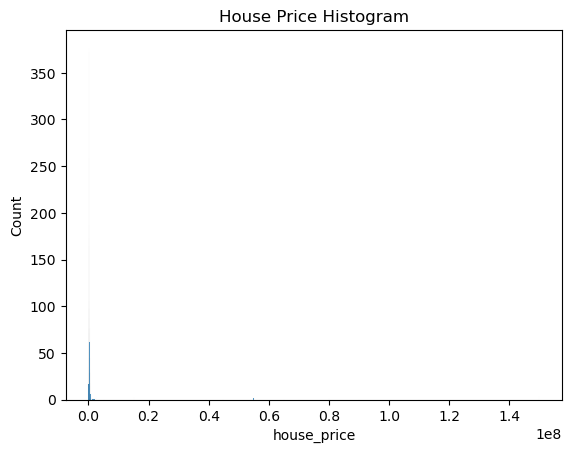

In [8]:
sns.histplot(df_samambaia[HOUSE_PRICE])
plt.title('House Price Histogram')

That's really bad. We can hardly see something. We'll calculate some formulas:

In [9]:
print('EXPLORING VARIABILITY OF PRICE')
print('---------------')
print(f'Median: {df_samambaia[HOUSE_PRICE].median():,}')
print(f'MAD: {mad(df_samambaia[HOUSE_PRICE]):,.2f}')
print('---------------')
print(f'Mean: {df_samambaia[HOUSE_PRICE].mean():,.2f}')
print(f'Standard deviation: {df_samambaia[HOUSE_PRICE].std():,.2f}')

EXPLORING VARIABILITY OF PRICE
---------------
Median: 209,000.0
MAD: 75,612.71
---------------
Mean: 698,515.34
Standard deviation: 6,946,811.10


It looks like the mean and standard deviation are shifted up by outliers, that is, extreme high prices are moving the mean to a higher value. We'll show the top 20 prices:

In [10]:
# MOST EXPENSIVE HOUSES
top_50_prices = df_samambaia[HOUSE_PRICE].sort_values()[-50:].values

for price in top_50_prices:
    print(f'{price:,.2f}')

700,000.00
700,000.00
700,000.00
750,000.00
770,000.00
779,000.00
780,000.00
780,000.00
810,000.00
850,000.00
890,000.00
900,000.00
990,000.00
1,100,000.00
1,199,999.00
1,250,000.00
1,250,000.00
1,300,000.00
1,350,000.00
1,400,000.00
1,500,000.00
1,670,000.00
1,690,000.00
2,000,000.00
2,549,999.00
2,550,000.00
2,600,000.00
2,600,000.00
2,600,000.00
2,600,000.00
2,800,000.00
3,500,000.00
5,080,000.00
15,000,000.00
15,000,000.00
15,000,000.00
39,000,000.00
44,900,000.00
54,900,000.00
54,900,000.00
65,000,000.00
69,900,000.00
79,900,000.00
79,900,000.00
89,900,000.00
109,900,000.00
150,000,000.00
150,000,000.00
150,000,000.00
150,000,000.00


We can see that there is a big jump of price from 5 to 15 million reais. Also, we see that houses up or equal to 1.5 million reais consist of 30 houses. Comparing to the total dataset of 2926 instances, by removing these houses we will have left 2896 houses, which corresponds of 98.97% of the original dataset. So, we will remove these houses using the code below:

In [11]:
upper_threshold = 1_500_000

df_samambaia = df_samambaia[df_samambaia[HOUSE_PRICE] < upper_threshold]
df_samambaia[HOUSE_PRICE].max()

1400000.0

Another issue we have is cheap houses. We will take a look at these values:

In [12]:
top_50_cheap_prices = df_samambaia[[HOUSE_PRICE, HOUSE_LINK]].sort_values(HOUSE_PRICE)[:50].values

print(top_50_cheap_prices)

[[0.0
  'https://df.olx.com.br/distrito-federal-e-regiao/imoveis/vendo-casa-samambaia-1092739942']
 [0.0
  'https://df.olx.com.br/distrito-federal-e-regiao/imoveis/vendo-casa-na-comercial-da-407-405-1114212208']
 [1.0
  'https://df.olx.com.br/distrito-federal-e-regiao/imoveis/aceito-proposta-1115347688']
 [1.0
  'https://df.olx.com.br/distrito-federal-e-regiao/imoveis/vendo-apartamentos-em-samambaia-sul-1117870403']
 [1.0
  'https://df.olx.com.br/distrito-federal-e-regiao/imoveis/vendo-apartamentos-em-samambaia-sul-1102425909']
 [30.0
  'https://df.olx.com.br/distrito-federal-e-regiao/imoveis/vendo-telhado-1114382647']
 [50.0
  'https://df.olx.com.br/distrito-federal-e-regiao/imoveis/agio-imperdivel-1109568870']
 [69.0
  'https://df.olx.com.br/distrito-federal-e-regiao/imoveis/giga-empresa-de-internet-1114510758']
 [100.0
  'https://df.olx.com.br/distrito-federal-e-regiao/imoveis/venda-troca-1118631835']
 [215.0
  'https://df.olx.com.br/distrito-federal-e-regiao/imoveis/apartamento-2q-

If you are still able to see the house description and the photos in the link, some of them are real houses for sale and some are not. Some houses are for rent. Some cheap houses have some kind of debt, called ágio, in portuguese. So, the threshold we will be using is very subjective. For this work, we will be using houses at or more expensive than R$ 25,000.00 reais.

In [13]:
down_threshold = 25_000

df_samambaia = df_samambaia[df_samambaia[HOUSE_PRICE] > down_threshold]
df_samambaia[HOUSE_PRICE].min()

29000.0

Now, we will compare the current dataset size to the original dataset. Also, we will see how mean and median, standard deviand and MAD looks like:

Dataset size: 97.57% from original
---------------------
New Mean: 236,979.94
Old mean: 698,515.34
---------------------
New median: 209,000.00
Old median: 209,000.00
---------------------
new std: 126,397.99
old std: 6,946,811.10
---------------------
new MAD: 74,130.11
old MAD: 75,612.71


Text(0.5, 1.0, 'House Price Histogram')

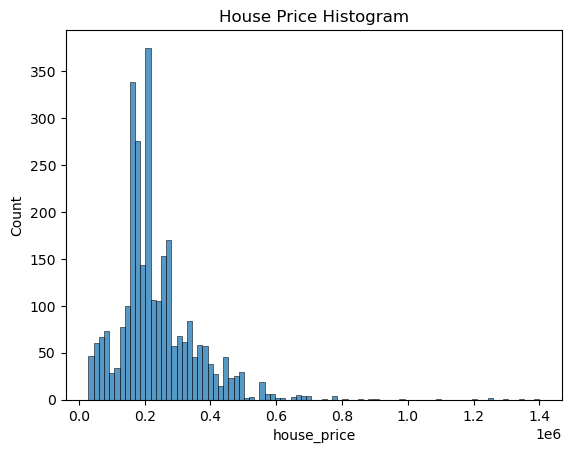

In [14]:
original_dataset_size = 2926
new_dataset_size = df_samambaia.shape[0]
mean = df_samambaia[HOUSE_PRICE].mean()
median = df_samambaia[HOUSE_PRICE].median()
std = df_samambaia[HOUSE_PRICE].std()

print(f'Dataset size: {100*new_dataset_size/original_dataset_size:.2f}% from original')
print('---------------------')
print(f'New Mean: {mean:,.2f}')
print(f'Old mean: 698,515.34')
print('---------------------')
print(f'New median: {median:,.2f}')
print('Old median: 209,000.00')
print('---------------------')
print(f'new std: {std:,.2f}')
print('old std: 6,946,811.10')
print('---------------------')
print(f'new MAD: {mad(df_samambaia[HOUSE_PRICE]):,.2f}')
print('old MAD: 75,612.71')

sns.histplot(df_samambaia[HOUSE_PRICE])
plt.title('House Price Histogram')

It looks much better now, in terms of house prices. As we can see, the new mean is much lower than the previous, and closer to the median. Also, the standard deviation is much lower too. so, this mean and standard deviantion are better indicators of samambaia house prices than the previous one - and we still have more than 97% of the original data, just by removing a few extreme values and not loosing too much data.

Now, let's move on to house size parameters and its histogram:

HOUSE SIZE
mean: 123.38m²
std: 1080.66m²
-------------------
median: 54.00m²
mad: 31.13m²
-------------------
min: 0.00m²
max: 47600.00m²


Text(0.5, 1.0, 'House Size Histogram')

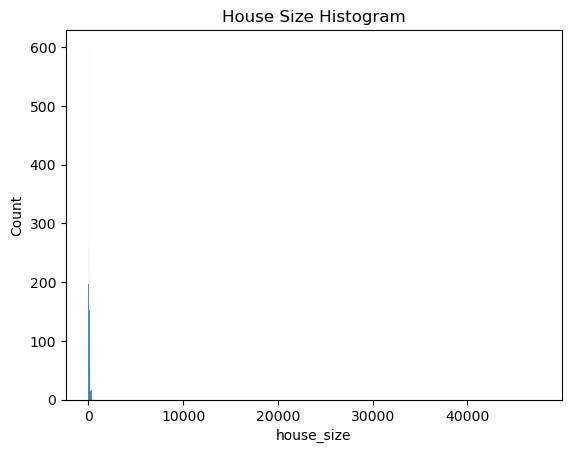

In [15]:
print('HOUSE SIZE')
print(f'mean: {df_samambaia[HOUSE_SIZE].mean():.2f}m²')
print(f'std: {df_samambaia[HOUSE_SIZE].std():.2f}m²')
print('-------------------')
print(f'median: {df_samambaia[HOUSE_SIZE].median():.2f}m²')
print(f'mad: {mad(df_samambaia[HOUSE_SIZE]):.2f}m²')
print('-------------------')
print(f'min: {df_samambaia[HOUSE_SIZE].min():.2f}m²')
print(f'max: {df_samambaia[HOUSE_SIZE].max():.2f}m²')

sns.histplot(df_samambaia[HOUSE_SIZE])
plt.title('House Size Histogram')

Again, the mean and standard deviation are very high, compared to the median and mad. And we hardly can see anything in the histogram. We'll print some huge house size values and see how it looks like:

In [16]:
df_samambaia[[HOUSE_SIZE, HOUSE_LINK]].sort_values(HOUSE_SIZE)[-30:].values

array([[400.0,
        'https://df.olx.com.br/distrito-federal-e-regiao/imoveis/casa-com-muito-conforto--aproveite-1031212019'],
       [400.0,
        'https://df.olx.com.br/distrito-federal-e-regiao/imoveis/vendo-casa-3-quartos-riacho-fundo-i-sucupira-condominio-jardim-dos-ipes-1114325104'],
       [400.0,
        'https://df.olx.com.br/distrito-federal-e-regiao/imoveis/qr-603-condominio-vida-nova-casa-de-400-m-com-7-quartos-em-samambaia-norte-1115786251'],
       [400.0,
        'https://df.olx.com.br/distrito-federal-e-regiao/imoveis/vendo-casa-no-incra-9-ceilandia-lote-de-400mts-1112599424'],
       [400.0,
        'https://df.olx.com.br/distrito-federal-e-regiao/imoveis/qr-603-condominio-vida-nova-casa-de-400m-com-7-quartos-em-samambaia-norte-r-345-000-00-1118343010'],
       [400.0,
        'https://df.olx.com.br/distrito-federal-e-regiao/imoveis/casa-para-venda-com-400-metros-quadrados-com-7-quartos-em-samambaia-norte-brasilia-df-1095548004'],
       [400.0,
        'https://df

Some houses description might have the area land, not the building area. So, this makes the house much bigger than it really is. We'll be removing some extreme values by a subjective threshold. We will be removing houses bigger than 900m². The code below remove those:

In [17]:
df_samambaia = df_samambaia[df_samambaia[HOUSE_SIZE] < 900]
df_samambaia[HOUSE_SIZE].max()

650.0

Houses of 0m² size actually means we could not get information about it. As this is not our target variable (house price is the target and the dependent variable), we'll see how much of 0m² in percentile:

In [18]:
size_zeros = df_samambaia[df_samambaia[HOUSE_SIZE] == 0].shape[0]
tota_size = df_samambaia.shape[0]
print(f'We have {100*size_zeros/tota_size:.2f}% of house sizes of zeros in the dataset')

We have 6.54% of house sizes of zeros in the dataset


This is not bad. We might inpute those values in the machine learning models. Before doing anything, we just might indicate that these are actually null values:

In [19]:
df_samambaia[HOUSE_SIZE] = df_samambaia[HOUSE_SIZE].map(lambda x: np.nan if x==0 else x).copy()

In [20]:
100*df_samambaia.isnull().sum()/df_samambaia.shape[0]

house_price           0.000000
house_region          0.000000
n_bedrooms            0.000000
has_condominium       0.000000
value_condominium     0.000000
has_garage            0.000000
n_garage              0.000000
house_size            6.537786
house_hyperlink       0.000000
house_category       14.762742
n_bathrooms          15.465729
zip_code             14.762742
street_address       16.836555
metro_distance        0.000000
dtype: float64

Now, we will look at the metrics we first saw in this section about house size. Also, we will compare the new dataset size with the original dataset size.

METRICS
Size: 97.23% of the original dataset
------------------
old mean: 123.84m²
new mean: 92.81m²
-------------------
old std: 1080.23m²
new std: 74.23m²
-------------------
old median: 54.00m²
new median: 59.00m²
-------------------
old mad: 31.13m²
new mad: nanm²
-------------------


Text(0.5, 1.0, 'House Size Histogram')

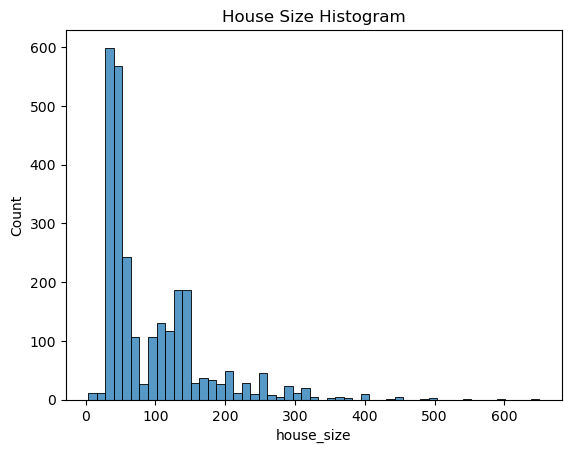

In [21]:
dataset_size = df_samambaia.shape[0]
old_size = 2926

print('METRICS')
print(f'Size: {100*dataset_size/old_size:.2f}% of the original dataset')
print('------------------')
print('old mean: 123.84m²')
print(f'new mean: {df_samambaia[HOUSE_SIZE].mean():.2f}m²')
print('-------------------')
print('old std: 1080.23m²')
print(f'new std: {df_samambaia[HOUSE_SIZE].std():.2f}m²')
print('-------------------')
print('old median: 54.00m²')
print(f'new median: {df_samambaia[HOUSE_SIZE].median():.2f}m²')
print('-------------------')
print('old mad: 31.13m²')
print(f'new mad: {mad(df_samambaia[HOUSE_SIZE]):.2f}m²')
print('-------------------')

sns.histplot(df_samambaia[HOUSE_SIZE])
plt.title('House Size Histogram')

We made huge improviments to analyse data later on by removing these values. There are other kind of approachs for outliers and leading with missing data, but for this quick analysis, losing less than 3% of the dataset might not seem a big problem.

### Create train and test datasets

You might wonder: Why create a train and test files? Well, I was reading this book (Hands on Machine Learning with scikit-learn by Aurélien Géron - Chapter 2, page 54) and the book says that we must split our data before doing any analysis. This is because, in the next part of this project, we'll build machine learning models. So, if we see all the data and make a huge data analysis in all data, we'll probably see some patterns and bias our models.

And this is not what we want. We want models to generalize. So, we'll split the data so we'll look only for train dataset.

In [22]:
# make sure the suffle is equal each time it runs by setting seed value
np.random.seed(0)

# Shuffle the rows
df = df_samambaia.sample(frac=1)

# Split into 70% train and 30% test
split = int(.7 * df.shape[0])

# Train and test
df_train = df[:split]
df_test = df[split:]

# Save files locally
df_train.to_csv('./data/train.csv')
df_test.to_csv('./data/test.csv')

# Showing size of train, test and original dataset
df_train.shape[0], df_test.shape[0], df.shape[0]

(1991, 854, 2845)

### Exploratory Data Analysis

#### The big picture

Remember we started our assumptions that house size, house category and the house distance to the train station are the most important features on price. This is important so we can see whether there is a real impact of these features on price or not.

The first thing we'll do is see the price feature:

In [237]:
title = '<b>Distribuição dos preços dos imóveis da Samambaia</b>'
subtitle = '<br><sub><i>     Em média, os imóveis na Samambaia custam 235 mil reais.\
 Segundo a figura à esquerda, 75% dos imóveis custam até 280 mil reais.<i></sub>'
title += subtitle

FIGURE_BG_COLOR = '#f4f4f4'


df = df_train[[HOUSE_REGION, HOUSE_PRICE]].groupby(HOUSE_REGION).mean().reset_index()

fig = make_subplots(rows = 1, cols = 2, column_widths=[0.25, 0.75])

## ADDING FIGURES

# Figure 1
fig.add_trace(
    go.Box(
        y = df_train[HOUSE_PRICE],
        showlegend = False,
        name = "Samambaia's properties",
        line_color = '#456357',
        fillcolor = '#63A088',
        marker_size = 3,
        jitter = .06),
    col = 1,
    row = 1)

# Figure 2
fig.add_trace(
    go.Histogram(
        x = df_train[HOUSE_PRICE],
        showlegend=False,
        name = '',
        marker=dict(color ='#63A088',
                    line = dict(color='black', width=.6))), 
    col = 2, 
    row = 1)

fig.update_layout(
    title = title,
    titlefont = {'size': FIGURE_TITLE_SIZE},
    template = 'simple_white',
    paper_bgcolor = FIGURE_BG_COLOR,
    plot_bgcolor = FIGURE_BG_COLOR,
)

fig.update_xaxes(showgrid = False)

fig.update_yaxes(
    showgrid = True,
    gridcolor = FIGURE_GRID_COLOR,
    gridwidth = 0.7
)

fig['layout']['yaxis']['title'] = 'Price (R$)'
fig['layout']['yaxis2']['title'] = 'Property amount'
fig['layout']['xaxis2']['title'] = 'Price (R$)'

fig.show()

At the left, we have a boxplot showing us that:
* Most houses and appartments (75%) values 280k at most, in Samambaia;
* A few houses costs more than R$ 440k.

In average, houses and appartments cost R$ 235k. In the histogram, we can see some outliers. But, in general, we have a good distribution shape of prices.

Now, we'll see our first assumption, house category in terms of price:

In [245]:
title = '<b>Preços dos imóveis na Samambaia por categoria</b>'
subtitle = '<br><sub><i>         Na Samambaia, apartamentos e casas custam, em média, 206 e 269 mil reais, respectivamente.\
 Além disso, 75% dos apartamentos <br>           custam até 230 mil reais, no máximo; para casas, este\
 valor é de 340 mil reias.</i></sub>'
title += subtitle

df = df_train.copy()
df[HOUSE_CATEGORY] = df_train[HOUSE_CATEGORY]\
        .apply(lambda x: 'Appartments' if x == 'Apartamentos' else 'Houses')

fig = make_subplots(
        rows = 1,
        cols = 1)

# Figure 1: Boxplot
fig.add_trace(
    go.Box(
        x = df[HOUSE_CATEGORY],
        y = df[HOUSE_PRICE],
        showlegend = False,
        jitter=0.04,
        marker_size=4,
        line_color = '#456357',
        fillcolor = '#63A088'),
    col = 1,
    row = 1)


fig.update_layout(
    title = title,
    titlefont = {'size':FIGURE_TITLE_SIZE},
    paper_bgcolor = FIGURE_BG_COLOR,
    plot_bgcolor = FIGURE_BG_COLOR,
    template = 'simple_white',
)

fig.update_xaxes(
    showgrid = False,
    tickfont_size = FIGURE_TICKFONT_SIZE,
    color = FIGURE_AXES_COLOR,
    
)

fig.update_yaxes(
    color = FIGURE_AXES_COLOR,
    showgrid = True,
    gridwidth = 0.8, 
    gridcolor = FIGURE_GRID_COLOR,
    tickfont_size = FIGURE_TICKFONT_SIZE,
)

fig['layout']['xaxis']['title'] = 'Category'
fig['layout']['yaxis']['title'] = 'Price (R$)'

# fig.show(renderer="svg")
fig.show()

What we have here:
* 75% of houses costs at most 340k, by contrast, 75% of appartments costs  230k at most;
* In average, houses cost 269k and appartments cost 206k;

So, that's a good indicator that houses cost more than appartments, as we thought in our hypothesis. Let's see the metro distance to houses and appartments:

In [143]:
title = '<b>Preços dos imóveis na Samambaia agrupados pela distância em relação ao metrô</b>'
subtitle = '<br><sub><i>      Imóveis a 1km e 2km de distância do metrô apresentam preços\
 similares, com médias de 289 e 290 mil reais, respectivamente.<br>\
             Imóveis a 3km de distância ou mais do metrô apresentam preços menores, com média de 223 mil reais.\
             </i></sub>'
title += subtitle

fig = make_subplots(rows = 1, cols = 1)

fig.add_trace(
    go.Box(
        x = df_train['metro_distance'],
        y = df_train[HOUSE_PRICE],
#         boxpoints='all',
        jitter=0.06,
#         whiskerwidth=0.2,
        marker_size=4,
        line_color = '#456357',
        fillcolor = '#63A088'),
    col = 1,
    row = 1)

fig.update_layout(
    title = title,
    titlefont = {'size': 19},
    template = 'simple_white',
    plot_bgcolor = FIGURE_BG_COLOR,
    paper_bgcolor = FIGURE_BG_COLOR
)

fig.update_xaxes(showgrid = False)

fig.update_yaxes(
    showgrid = True,
    gridcolor = FIGURE_GRID_COLOR,
    gridwidth = .8,
)

fig['layout']['xaxis']['title'] = 'Property distance to the metro station (km)'
fig['layout']['yaxis']['title'] = 'Price (R$)'

fig.show()

As the distance increases from 1km to 2km, there is no difference. From 2km to 3km there is a difference, but there is also outliers (high values as we can see). So, the difference is there, but not too much.

Last but not least, the bulding size versus price:

In [164]:
title = '<b>Comparando preços e tamanho dos imóveis na Samambaia</b>'
subtitle = '<br><sub><i>       Observando os pontos no gráfico, é possível perceber que há um crescimento \
nos preços à medida que os imóveis aumentam <br>            de tamanho. Contudo, essa correlação não é tão evidente.</i><sub>'
title += subtitle

fig = make_subplots(rows = 1, cols = 1,)

fig.add_trace(
    go.Scatter(
        x = df_train[HOUSE_SIZE],
        y = df_train[HOUSE_PRICE],
        mode = 'markers',
        showlegend = False),
    row = 1, col = 1)

fig.update_layout(
    title = title,
    titlefont = {'size': FIGURE_TITLE_SIZE},
    paper_bgcolor = FIGURE_BG_COLOR,
    plot_bgcolor = FIGURE_BG_COLOR,
    template = 'simple_white'
)

fig.update_traces(marker_line_width=.3, marker_size = 8)

fig.update_xaxes(
    showgrid = True,
    gridcolor = '#ebebeb',
    gridwidth = .4
)

fig.update_yaxes(
    showgrid = True,
    gridcolor = '#ebebeb',
    gridwidth = .4
)

fig['layout']['xaxis']['title'] = 'Property size (m²)'
fig['layout']['yaxis']['title'] = 'Price (R$)'

fig.show()

Hard to say, but looks like size increases, the price too, in most cases. But there are also some houses or appartments that are big but cost low. My thought on that is, there a simple houses far from the center of the city that are big but cost low because of location. That might explain this cases, so it is good to investigate eventually.

#### Explore correlations

We've seen some graphs but they're not a satisfatory explanation of house (or appartment) price changes. Also, we cannot trust only our assumptions, we have to use science, look for other directions and see what data is showing us.

For that, We'll build a heatmap that shows the correlation among various numeric attributes. This is done by using a correlation matrix calculated but the pandas library. So, let's get started and see if we find something interesting:

In [27]:
corr = df_train.drop('zip_code', axis = 1).corr()
labels = ['Valor imóvel', 'N banheiro', 'Condomínio', 'N garagem', 'Tamanho casa', 'Metrô distância']
title = '<b>Correlação entre variáveis numéricas dos imóveis da Samambaia</b>'


fig = px.imshow(corr, width=900, height=800, 
                y = labels, x = labels, text_auto=True, color_continuous_scale=px.colors.sequential.amp)

# fig.update_traces()
fig.update_layout(
    title = title)

fig.update_xaxes(side="top")

fig.show()

That information given by a heatmap is beautiful, isn't it? The first line shows the attributes related to price. For houses and appartments, the size, number of bathrooms and n parking spaces are the three that most influences price. Another interesting thing is that the size and the number of bathrooms; and the size and number of parking spaces are highly correlated. As we're focusing on price, we'll explore that way more.

My guess is that we should not threat houses and appartments equal. We've seen that houses and appartment distribution prices are not similar, so there might be differences. So, we'll split that to explore more information. Again, we'll make more two heatmaps to see each category more closely:

#### Looking at house category separately

First, category equals houses:

In [28]:
corr = df_train.drop('zip_code', axis = 1)[df_train[HOUSE_CATEGORY] == 'Casas'].corr()


labels = ['Valor imóvel', 'N banheiro', 'Condomínio', 'N garagem', 'Tamanho casa', 'Metrô distância']
title = '<b>Correlação entre variáveis numéricas das Casas da Samambaia</b>'


fig = px.imshow(corr, width=900, height=800, 
                y = labels, x = labels, text_auto=True, color_continuous_scale=px.colors.sequential.amp)

# fig.update_traces()
fig.update_layout(
    title = title)

fig.update_xaxes(side="top")

fig.show()

Gerenally, we've seen that the size, number of bathrooms and number of parking spaces most influeced the price or houses and appartments together. Now, looking only for category of houses, we see that number of bathrooms and the house size influences most, respectively, but not too much the parking spaces. Taking a look at other columns, house size and the number of bathrooms are a little bit correlated.

Now, let us see the appartment category correlation variables:

In [29]:
corr = df_train.drop('zip_code', axis = 1)[df_train[HOUSE_CATEGORY] == 'Apartamentos'].corr()


labels = ['Valor imóvel', 'N banheiro', 'Condomínio', 'N garagem', 'Tamanho casa', 'Metrô distância']
title = '<b>Correlação entre variáveis numéricas dos apartamentos da Samambaia</b>'


fig = px.imshow(corr, width=900, height=800, 
                y = labels, x = labels, text_auto=True, color_continuous_scale=px.colors.sequential.amp)

# fig.update_traces()
fig.update_layout(
    title = title)

fig.update_xaxes(side="top")

fig.show()

Well, this is so interesting! Appartments have a strong relation to its size. The number of parking spaces and number of bathrooms follows the other two good relation to appartment prices. Looking for other variables, appartment size and number of bathrooms, and appartment size and the parking spaces also have a medium correlation, one might be related to another.

So, this is the big picture about house prices now, we'll take a closer look at the most interesting ones considering those heatmaps we've seen.

#### Univariative analysis

We'll just see if there is an outlier regards to the house price value. To do that in a statistical manner, we'll standardize the data with mean of zero and see how the outer range looks like:

In [30]:
scaler = StandardScaler().fit(df_train[HOUSE_PRICE].values.reshape(-1,1)[:np.newaxis])
scaled_houseprices = scaler.transform(df_train[HOUSE_PRICE].values.reshape(-1,1))
low_range = scaled_houseprices[scaled_houseprices[:,0].argsort()][:10]
high_range= scaled_houseprices[scaled_houseprices[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.74051786]
 [-1.74051786]
 [-1.74051786]
 [-1.73207563]
 [-1.73207563]
 [-1.73207563]
 [-1.6898138 ]
 [-1.6898138 ]
 [-1.6898138 ]
 [-1.68136313]]

outer range (high) of the distribution:
[[3.9298854 ]
 [4.35241918]
 [4.52143269]
 [4.59748877]
 [4.60593944]
 [4.85945971]
 [5.19748673]
 [5.6200205 ]
 [7.3101556 ]
 [8.1552147 ]]


Low house price values seems ok, because the mean of 0 is not too farm from these values. Unfortunately, the high values a far away from 0 and then we must be careful, this might indicate them as outliers.

#### Bivariate analysis

We've already seem some of this scatter plots, but taking a better look we might see something different:

In [246]:
title = '<b>Comparando preços e tamanho dos imóveis na Samambaia por categoria</b>'
subtitle = '<br><sub><i>          Casas e apartamentos apresentam aumento de preços à medida que o tamanho dos imóveis aumentam.\
<br>               Para apartamentos, essa correlação é ainda mais acentuada.</i><sub>'
title += subtitle

df = df_train.copy()
df[HOUSE_CATEGORY] = df_train[HOUSE_CATEGORY]\
        .apply(lambda x: 'Appartments' if x == 'Apartamentos' else 'Houses')

fig = px.scatter(df, x = HOUSE_SIZE, y = HOUSE_PRICE, color = HOUSE_CATEGORY, trendline = 'ols',
                labels = {'house_category': ""})

fig['layout']['xaxis']['title'] = 'Property size (m²)'
fig['layout']['yaxis']['title'] = 'Price (R$)'

fig.update_layout(
    title = title,
    titlefont = {'size': FIGURE_TITLE_SIZE},
    template = 'simple_white',
    paper_bgcolor = FIGURE_BG_COLOR,
    plot_bgcolor = FIGURE_BG_COLOR,
    legend=dict(
            orientation="h",
            yanchor="bottom",
            y=0.97,
            xanchor="right",
            x=1.044)
)

fig.update_traces(marker_line_width=.3, marker_size = 8)

fig.update_xaxes(
    showgrid = True,
    gridcolor = '#ebebeb',
    gridwidth = .4
)

fig.update_yaxes(
    showgrid = True,
    gridcolor = '#ebebeb',
    gridwidth = .4
)

fig['layout']['xaxis']['title'] = 'Property size (m²)'
fig['layout']['yaxis']['title'] = 'Price (R$)'

fig.show()

Look at the same scatter plot, but splitting into categories and yeap! More information is added! So, appartments are really more influence by its size than houses.

We have an appartament that is huge but not expensive. This point is something to be studied. Again, house price does not increase too much based on its size. Still, we can say that house size has effect on house price. We might be attempted to remove that huge appartament of low price, but we might leave that to be analyzed later on.

So, what most influence house prices then?

In [251]:
df = df_train.copy()
df[HOUSE_CATEGORY] = df_train[HOUSE_CATEGORY]\
        .apply(lambda x: 'Apartments' if x == 'Apartamentos' else 'Houses')

title = '<b>Comparando o preço e o número de banheiros dos imóveis na Samambaia</b>'
subtitle = '<br><sub><i>           O preço dos apartamentos aumentam conforme o número de banheiros aumenta\
.</i></sub>'
title += subtitle

list_order = [0, 1, 2, 3, 4, '5 ou mais']

fig = px.box(df, x = HOUSE_N_BATH, y = HOUSE_PRICE, title = title, color = HOUSE_CATEGORY, 
             category_orders={HOUSE_N_BATH: list_order}, labels = {'house_category': ""})

fig.update_layout(
    title = title,
    titlefont = {'size': FIGURE_TITLE_SIZE},
    template = 'simple_white',
    paper_bgcolor = FIGURE_BG_COLOR,
    plot_bgcolor = FIGURE_BG_COLOR,
    legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1)
)

fig.update_yaxes(
    showgrid = True,
    gridcolor = '#e8e8e8',
    gridwidth = .4
)

fig['layout']['xaxis']['title'] = 'Number of bathrooms'
fig['layout']['yaxis']['title'] = 'Price (R$)'

fig.show()

The number of 0 bathrooms actually indicates we have no information about that. For houses, the prices increase but not so much. For appartments, the prices increase a lot from 1 to 2 bathrooms, and from 2 to 3 bathrooms, this value increases even more; there are a few appartments with 5 bathrooms (this might be a typo on olx page or just outliers). 

In [250]:
df = df_train.copy()
df[HOUSE_CATEGORY] = df[HOUSE_CATEGORY]\
                        .apply(lambda x: 'Apartments' if x == 'Apartamentos' else 'Houses')

title = '<b>Comparando o preço e o número de garagens dos imóveis da Samambaia</b>'
subtitle = '<br><sub><i>        O preço dos apartamentos aumentam conforme o número de vagas na garagem aumentam\
.</i></sub>'
title += subtitle

# list_order = [0, 1, 2, 3, 4, '5 ou mais']

fig = px.box(df, x = HOUSE_N_PARKING, y = HOUSE_PRICE, title = title, color = HOUSE_CATEGORY, 
             labels = {'house_category': ""})

fig.update_layout(
    title = title,
    titlefont = {'size': FIGURE_TITLE_SIZE},
    template = 'simple_white',
    paper_bgcolor = FIGURE_BG_COLOR,
    plot_bgcolor = FIGURE_BG_COLOR,
    legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1)
)

fig.update_yaxes(
    showgrid = True,
    gridcolor = '#e8e8e8',
    gridwidth = .4
)

fig['layout']['xaxis']['title'] = 'Parking spaces'
fig['layout']['yaxis']['title'] = 'Price (R$)'

fig.show()

The number of garage does not seem to be affected by houses, but it does by appartments.

## Final considerations

Analysing things based on data makes us view the world in a different way. What we can abstract from here is that:

* Samambaia houses cost, in average, 230k. Additionally, 75% of properties cost 280k at most.

* In average, houses cost more than appartments; which cost in average 269k and 206, respectively. Additionally, 75% of houses cost 340k at most; as 75% of appartments cost 230k at most.

* For houses, the number of bathrooms has the strongest impact on house price; followed by house size, which has a moderated impact;

* For appartments, the size has a strong correlation to its price, followed by the number of bathrooms and parking spaces with moderated impact on its price;

* The distance factor to the train station is not strong at all for appartments, and a little bit moderated for houses. This is something that should be more explored to really confirm there is no correlation. By now, there is not.

That's it! Thank you so much for reaching here. If you read this, that means you're really interested in this project. The next notebook I will model machine learning models to learn from this data and predict house prices based on this features. Any comments or suggestions, feel free to comment on github or linkedin. See ya!